In [1]:
import os
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
#warnings.filterwarnings("ignore") #Hide messy Numpy warnings


Using TensorFlow backend.


In [2]:
def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

In [3]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [4]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
    output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

In [5]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [6]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

In [7]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]            
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [8]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()


In [9]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [19]:
global_start_time = time.time()
epochs  = 1
#seq_len = 50
seq_len = 5

In [32]:
#f = open('sp500.csv', 'rb').read()
f = open('test.csv', 'rb').read()
data = f.decode().split('\n')
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])
#result[0:2][0:10]
result

[['1', '2', '3', '4', '5', '6'],
 ['2', '3', '4', '5', '6', '7'],
 ['3', '4', '5', '6', '7', '8'],
 ['4', '5', '6', '7', '8', '9'],
 ['5', '6', '7', '8', '9', '10'],
 ['6', '7', '8', '9', '10', '11'],
 ['7', '8', '9', '10', '11', '12'],
 ['8', '9', '10', '11', '12', '13'],
 ['9', '10', '11', '12', '13', '14'],
 ['10', '11', '12', '13', '14', '15'],
 ['11', '12', '13', '14', '15', '16'],
 ['12', '13', '14', '15', '16', '17'],
 ['13', '14', '15', '16', '17', '18'],
 ['14', '15', '16', '17', '18', '19'],
 ['15', '16', '17', '18', '19', '20']]

In [33]:
#normalise_window = True
normalise_window = False
if normalise_window:
    result = normalise_windows(result)
#result[0:2][0:10]
result

[['1', '2', '3', '4', '5', '6'],
 ['2', '3', '4', '5', '6', '7'],
 ['3', '4', '5', '6', '7', '8'],
 ['4', '5', '6', '7', '8', '9'],
 ['5', '6', '7', '8', '9', '10'],
 ['6', '7', '8', '9', '10', '11'],
 ['7', '8', '9', '10', '11', '12'],
 ['8', '9', '10', '11', '12', '13'],
 ['9', '10', '11', '12', '13', '14'],
 ['10', '11', '12', '13', '14', '15'],
 ['11', '12', '13', '14', '15', '16'],
 ['12', '13', '14', '15', '16', '17'],
 ['13', '14', '15', '16', '17', '18'],
 ['14', '15', '16', '17', '18', '19'],
 ['15', '16', '17', '18', '19', '20']]

In [34]:
result = np.array(result)
result.shape

(15, 6)

In [40]:
#row = round(0.9 * result.shape[0])
row = round(0.7 * result.shape[0])
train = result[:int(row), :]
# shuffle ?!
np.random.shuffle(train)
x_train = train[:, :-1]
x_train

array([['9', '10', '11', '12', '13'],
       ['5', '6', '7', '8', '9'],
       ['8', '9', '10', '11', '12'],
       ['7', '8', '9', '10', '11'],
       ['3', '4', '5', '6', '7'],
       ['1', '2', '3', '4', '5'],
       ['2', '3', '4', '5', '6'],
       ['4', '5', '6', '7', '8'],
       ['6', '7', '8', '9', '10'],
       ['10', '11', '12', '13', '14']], 
      dtype='<U2')

In [41]:
y_train = train[:, -1]
y_train

array(['14', '10', '13', '12', '8', '6', '7', '9', '11', '15'], 
      dtype='<U2')

In [42]:
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((10, 5), (5, 5), (10,), (5,))

In [43]:
# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((10, 5, 1), (5, 5, 1), (10,), (5,))

In [44]:
layers = [1, 50, 100, 1]

model = Sequential()

model.add(LSTM(input_dim=layers[0], output_dim=layers[1], return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(layers[2], return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(output_dim=layers[3]))

model.add(Activation("linear"))
model

In [45]:
start = time.time()
model.compile(loss="mse", optimizer="rmsprop")
print("> Compilation Time : ", time.time() - start)

> Compilation Time :  0.14963412284851074


In [46]:
model.fit(x_train, y_train, batch_size=512, nb_epoch=epochs, validation_split=0.05)

Train on 9 samples, validate on 1 samples
Epoch 1/1
9/9 [==============================] - 0s - loss: 111.5597 - val_loss: 209.0950


In [48]:
# predict point by point
predicted = model.predict(x_test)
predicted

array([[ 0.52986002],
       [ 0.52332151],
       [ 0.51488209],
       [ 0.50800717],
       [ 0.50264663]], dtype=float32)

In [49]:
predicted = np.reshape(predicted, (predicted.size,))
predicted

array([ 0.52986002,  0.52332151,  0.51488209,  0.50800717,  0.50264663], dtype=float32)

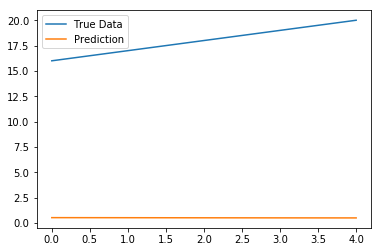

In [50]:
predictions1 = predict_point_by_point(model, x_test)    
plot_results(predictions1, y_test)

In [60]:
#Predict sequence of 50 steps before shifting prediction run forward by 50 steps
#prediction_len=50
prediction_len=5
prediction_seqs = []
for i in range(int(len(x_test)/prediction_len)):
    curr_frame = x_test[i*prediction_len]
    predicted = []
    for j in range(prediction_len):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]            
        curr_frame = np.insert(curr_frame, [seq_len-1], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
prediction_seqs

[[0.52986026, 0.52737224, 0.46806818, 0.37166306, 0.23924975]]

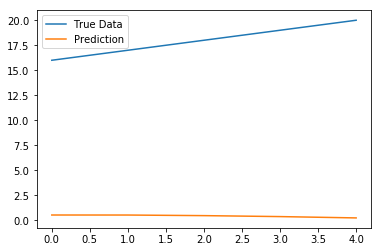

In [61]:
#predictions3 = predict_sequences_multiple(model, x_test, seq_len, 50)
predictions3 = predict_sequences_multiple(model, x_test, seq_len, 5)
plot_results_multiple(predictions3, y_test, 50)

In [53]:
#Shift the window by 1 new prediction each time, re-run predictions on new window
curr_frame = x_test[0]
predicted = []
for i in range(len(x_test)):
    predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
    curr_frame = curr_frame[1:]
    curr_frame = np.insert(curr_frame, [seq_len-1], predicted[-1], axis=0)
predicted

[0.52986026, 0.52737224, 0.46806818, 0.37166306, 0.23924975]

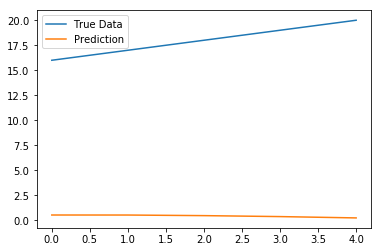

In [55]:
predictions2 = predict_sequence_full(model, x_test, seq_len)
plot_results(predictions2, y_test)